In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/kamilabielska/gans

In [3]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as layers

from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

from gans.gans.models import GAN, ProGAN
from gans.gans.layers import GaussianNoiseAnnealing, PixelNorm, MinibatchSTD
from gans.gans.callbacks import SaveGeneratedImages, GaussianSTDAnnealing

from gans.utils.vizualization import plot_sample_images, plot_history, gif_from_image_folder

sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.25)


# get anime data

In [4]:
!cp -r 'drive/My Drive/anime.zip' .

In [5]:
!unzip -q anime.zip
!rm anime.zip

In [6]:
size = 96
batch_size = 128
folder_name = 'images'

# prepare data

In [7]:
n_channels = 3
conditional = False

In [8]:
color_mode = {
    1: 'grayscale',
    3: 'rgb'
}
label_mode = None if not conditional else 'categorical'

In [9]:
dataset_kwargs = dict(
    label_mode=label_mode,
    batch_size=batch_size,
    image_size=(size, size),
    color_mode=color_mode[n_channels],
    crop_to_aspect_ratio=True,
    shuffle=True,
    seed=42
)

In [10]:
train_data = image_dataset_from_directory(folder_name, **dataset_kwargs)

Found 63565 files belonging to 1 classes.


In [11]:
rescaling_layer = layers.Rescaling(scale=1./127.5, offset=-1.)
rescale = rescaling_layer if not conditional else lambda x, y: (rescaling_layer(x), y)
train_data = train_data.map(rescale)

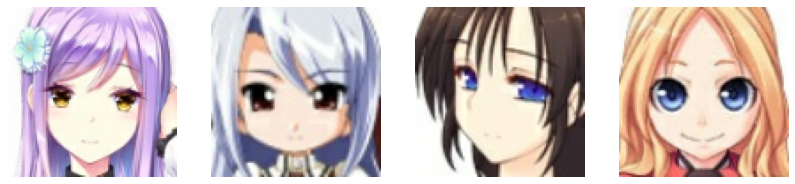

In [12]:
plot_sample_images(train_data if not conditional else train_data.map(lambda x, y: x), rescaled=True)

# deep convolutional GAN

In [13]:
latent_dim = 128
classes = [] if not conditional else train_data.class_names
gen_input_dim = latent_dim + len(classes)

alpha = 0.2
conv_kwargs = dict(
    kernel_size=3,
    strides=1,
    padding='same',
    kernel_initializer='he_normal',
    use_bias=False
)

In [14]:
init_size = size // 2**3

In [15]:
def conv_block(n_filters, alpha=0.2, **kwargs):
    block = Sequential([
        layers.Conv2D(filters=n_filters, **kwargs),
        layers.LeakyReLU(alpha),
        layers.BatchNormalization(),
    ])
    return block

In [16]:
generator = Sequential([
    layers.Input(shape=[gen_input_dim]),
    layers.Dense(units=init_size * init_size * 256),
    layers.LeakyReLU(alpha),

    layers.Reshape([init_size, init_size, 256]),

    conv_block(256, alpha=alpha, **conv_kwargs),
    conv_block(256, alpha=alpha, **conv_kwargs),
    layers.UpSampling2D(),
    GaussianNoiseAnnealing(0.1),
    
    conv_block(128, alpha=alpha, **conv_kwargs),
    layers.UpSampling2D(),
    GaussianNoiseAnnealing(0.1),

    conv_block(64, alpha=alpha, **conv_kwargs),
    layers.UpSampling2D(),
    GaussianNoiseAnnealing(0.1),

    layers.Conv2D(
        filters=n_channels, kernel_size=3,
        padding='same', activation='tanh')
])

In [17]:
discriminator = Sequential([
    layers.Input(shape=[size, size, n_channels + len(classes)]),
    GaussianNoiseAnnealing(0.1),

    conv_block(32, alpha=alpha, **conv_kwargs),
    layers.AveragePooling2D(),
    layers.Dropout(0.3),

    conv_block(64, alpha=alpha, **conv_kwargs),
    layers.AveragePooling2D(),
    
    conv_block(128, alpha=alpha, **conv_kwargs),
    layers.AveragePooling2D(),
    MinibatchSTD(),

    conv_block(256, alpha=alpha, **conv_kwargs),
    conv_block(256, alpha=alpha, **conv_kwargs),
    layers.AveragePooling2D(),
    layers.Dropout(0.5),

    layers.GlobalMaxPooling2D(),
    layers.Dense(units=1)
])

In [21]:
noise = tf.random.normal([4, latent_dim])
callbacks = [
    SaveGeneratedImages(data=noise, path='drive/MyDrive/anime_progress'),
    SaveGeneratedImages(n=4, path='drive/MyDrive/anime_random'),
    GaussianSTDAnnealing(0.00001)
]

loss = 'bce'

opt_params = {
    'bce': {
        'learning_rate': 2e-4,
        'beta_1': 0.5
    },
    'wgan_gp': {
        'learning_rate': 1e-4,
        'beta_1': 0,
        'beta_2': 0.9
    }
}

In [22]:
gan = GAN(generator, discriminator, classes=classes, gp_weight=0)
gan.compile(
    gen_optimizer=tf.keras.optimizers.Adam(**opt_params[loss]),
    disc_optimizer=tf.keras.optimizers.Adam(**opt_params[loss]),
    loss_type=loss,
    label_smoothing=True
)

In [ ]:
fit = gan.fit(train_data, epochs=80, callbacks=callbacks)

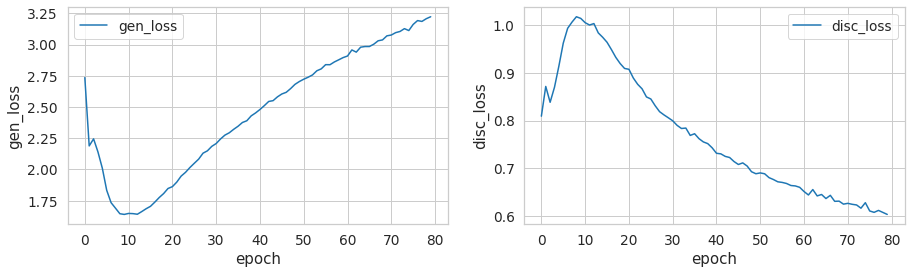

In [ ]:
plot_history(fit, ['gen_loss', 'disc_loss'], val=False)

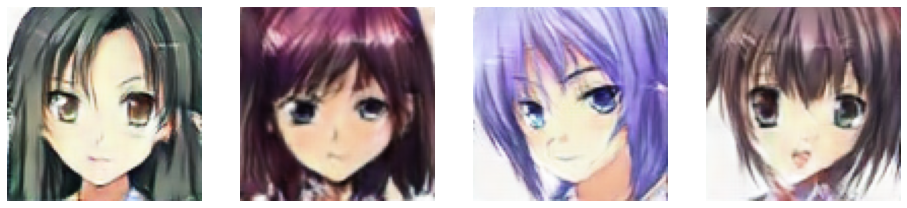

In [ ]:
gan.generate_new_samples(n=4)

In [ ]:
gif_from_image_folder('drive/My Drive/anime_progress', 'drive/MyDrive/gan_progress.gif')

# progressive growing of GANs

In [13]:
def building_block(n_filters, alpha=0.2, pixel_norm=False, **kwargs):
    name = fr'conv_block_{n_filters[0]}_{n_filters[1]}'
    norm_layer = PixelNorm if pixel_norm else layers.BatchNormalization
    block = Sequential([
        layers.Conv2D(filters=n_filters[0], **kwargs),
        layers.LeakyReLU(alpha),
        norm_layer(),
        layers.Conv2D(filters=n_filters[1], **kwargs),
        layers.LeakyReLU(alpha),
        norm_layer(),
    ], name=name)
    return block

def gen_output_layer(name=None):
    return layers.Conv2D(
        filters=n_channels, kernel_size=1, padding='same',
        name=name)

def disc_input_layer(n_filters, alpha=0.2, name=None):
    return Sequential([
        layers.Conv2D(filters=n_filters, kernel_size=1, padding='same'),
        layers.LeakyReLU(alpha)
    ], name=name)

In [14]:
latent_dim = 128
classes = [] if not conditional else train_data.class_names
gen_input_dim = latent_dim + len(classes)

alpha = 0.2
conv_kwargs = dict(
    kernel_size=3,
    padding='same',
    kernel_initializer='he_normal'
)

In [15]:
init_size = size // 2**3
init_n_filters = 256

In [16]:
input_layer = layers.Input(shape=[gen_input_dim])
g = layers.Dense(units=init_size * init_size * init_n_filters)(input_layer)
g = layers.LeakyReLU(alpha)(g)
g = layers.Reshape([init_size, init_size, init_n_filters])(g)

g = layers.Conv2D(filters=init_n_filters, kernel_size=4, padding='same')(g)
g = layers.LeakyReLU(alpha)(g)
g = layers.BatchNormalization()(g)
g = layers.Conv2D(filters=init_n_filters, kernel_size=3, padding='same')(g)
g = layers.LeakyReLU(alpha)(g)
g = layers.BatchNormalization()(g)

output = gen_output_layer(name='to_rgb')(g)
output = layers.Activation(tf.keras.activations.tanh, name='to_skip_tanh')(output)

generator = tf.keras.Model(inputs=input_layer, outputs=output)

In [17]:
input_layer = layers.Input(shape=[init_size, init_size, n_channels+len(classes)], name='to_skip_input')
d = disc_input_layer(init_n_filters, name='from_rgb')(input_layer)

d = MinibatchSTD()(d)
d = layers.Conv2D(filters=init_n_filters, kernel_size=3, padding='same')(d)
d = layers.LeakyReLU(alpha)(d)
d = layers.BatchNormalization()(d)
d = layers.Conv2D(filters=init_n_filters, kernel_size=4, padding='same')(d)
d = layers.LeakyReLU(alpha)(d)
d = layers.BatchNormalization()(d)
d = layers.Dropout(0.3)(d)

d = layers.GlobalMaxPooling2D()(d)
output = layers.Dense(units=1)(d)

discriminator = tf.keras.Model(inputs=input_layer, outputs=output)

In [18]:
loss = 'bce'

opt_params = {
    'bce': {
        'learning_rate': 2e-4,
        'beta_1': 0.5
    },
    'wgan_gp': {
        'learning_rate': 5e-4,
        'beta_1': 0,
        'beta_2': 0.99,
        'epsilon': 1e-08
    }
}

In [19]:
progan = ProGAN(
    generator=generator, discriminator=discriminator,
    classes=classes, gp_weight=0
)
progan.compile(
    gen_optimizer=tf.keras.optimizers.legacy.Adam(**opt_params[loss]),
    disc_optimizer=tf.keras.optimizers.legacy.Adam(**opt_params[loss]),
    loss_type=loss,
    label_smoothing=True,
    building_block=building_block,
    block_kwargs=conv_kwargs,
    gen_output_layer=gen_output_layer,
    disc_input_layer=disc_input_layer,
    init_n_filters=init_n_filters,
    drift=0
)

In [20]:
gen_images_path = 'drive/MyDrive/anime_progress_progan'
model_graph_path = 'drive/MyDrive/gan_growing'

In [21]:
noise = tf.random.normal([4, latent_dim])
callbacks = tf.keras.callbacks.CallbackList(
    callbacks=[SaveGeneratedImages(data=noise, path=gen_images_path)],
    model=progan
)

In [ ]:
progan.train(train_data, 80, 8, model_graph_path=model_graph_path, callbacks=callbacks)

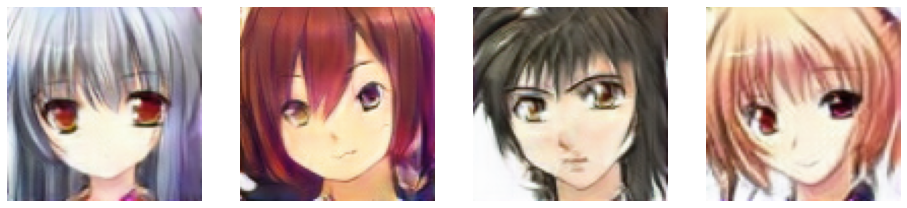

In [29]:
progan.generate_new_samples()

In [30]:
gif_from_image_folder('drive/My Drive/anime_progress_progan', 'drive/MyDrive/progan_progress.gif')